In [3]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.evaluator import Evaluator
import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, BatchNormalization, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/liingfeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train = Loader.load_NLP()

/home/liingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the ori

In [5]:
descriptions = [col for col in train.columns if "description" in col]

print(descriptions)

def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
#train[descriptions].apply(lambda col: col.apply(lambda x: type(x).__name__).value_counts())

#descriptions.append("idx")
#descriptions.append("price")
#descriptions.append("km")

['motor_description', 'transmission_description', 'parking_sensors_description', 'Exterior_Llantas_description', 'Exterior_Molduras_description', 'Exterior_Neumáticos_description', 'Exterior_Puerta_description', 'Exterior_Retrovisor_description', 'Confort_Volante_description', 'seat_description', 'head_supporter_description']


In [6]:
filtered_columns = ["price", "km", "fuelType", "full_description"]
train = train[filtered_columns]
train["price_per_kilometer"] = train["price"]/train["km"]
train.dropna(inplace=True)
train

,price,km,fuelType,full_description,price_per_kilometer
idx,,,,,
118198,29500,20000.0,Gasolina,"Motor de 2,0 litros ( 1.998 cc ) , cuatro cili...",1.475000
118199,23500,15.0,Diésel,"Motor de 1,5 litros ( 1.498 cc ) , cuatro cili...",1566.666667
118200,4500,210000.0,Diésel,"Motor de 1,4 litros ( 1.398 cc ) , cuatro cili...",0.021429
118201,5999,239000.0,Diésel,"Motor de 2,0 litros ( 1.968 cc ) , 4 cilindros...",0.025100
118202,42990,56140.0,Diésel,"Motor de 2,1 litros ( 2.143 cc ) , cuatro cili...",0.765764
...,...,...,...,...,...
47252,15350,126989.0,Diésel,"Motor de 1,6 litros ( 1.598 cc ) , cuatro cili...",0.120877
47253,38840,92989.0,Diésel,"Motor de 2,0 litros ( 1.968 cc ) , cuatro cili...",0.417684
47254,16980,46000.0,Gas licuado (GLP),"Motor de 1,0 litros ( 999 cc ) , tres cilindro...",0.369130


In [7]:
#Parameters
verb_size = 200

In [8]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales (pero mantener los números)
    text = text.lower()
    text = re.sub(r'[^\w\s\d]', '', text)  # Eliminar signos de puntuación, pero mantener números
    tokens = text.split()
    
    # Filtrar tokens, eliminando las stopwords
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    
    return filtered_tokens

train['tokens'] = train['full_description'].apply(preprocess_text)
model_w2v = Word2Vec(sentences=train['tokens'], vector_size=verb_size, window=1, min_count=3, workers=8)
word_vectors = model_w2v.wv

def get_average_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size) 
train['embedding'] = train['tokens'].apply(lambda x: get_average_embedding(x, word_vectors))

In [9]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['fuelType'])
train_df.head()

,price,km,fuelType,full_description,price_per_kilometer,tokens,embedding
idx,,,,,,,
87070,53990,90147.0,Híbrido enchufable,"Motor de 3,0 litros ( 2.995 cc ) , seis cilind...",0.598911,"[motor, 30, litros, 2995, cc, seis, cilindros,...","[0.0777806, 0.026397564, -0.11621852, 0.502372..."
25153,59479,0.0,Eléctrico,no tiene motor_description Transmisión de tipo...,inf,"[motor_description, transmisión, tipo, automát...","[0.12196377, 0.10067558, -0.14919718, 0.490191..."
137368,14300,179837.0,Diésel,"Motor de 2,1 litros ( 2.143 cc ) , cuatro cili...",0.079516,"[motor, 21, litros, 2143, cc, cuatro, cilindro...","[0.12791398, 0.007957331, -0.14787155, 0.35935..."
95227,23500,69365.0,Diésel,"Motor de 1,6 litros ( 1.598 cc ) , cuatro cili...",0.338788,"[motor, 16, litros, 1598, cc, cuatro, cilindro...","[0.16534153, 0.069525875, -0.12593144, 0.30919..."
145082,11500,74577.0,Gasolina,"Motor de 0,9 litros ( 898 cc ) , tres cilindro...",0.154203,"[motor, 09, litros, 898, cc, tres, cilindros, ...","[0.0699091, 0.032097723, -0.10167921, 0.482173..."


In [10]:
def custom_loss(y_true, y_pred):
    # Penalizar mas los valores negativos
    loss = tf.where(y_pred < 0, tf.square(y_pred - y_true) * 10, tf.square(y_pred - y_true))
    return tf.reduce_mean(loss)

In [11]:

x_embeddings = np.stack(train_df["embedding"].values)

x_km = train_df['km'].to_numpy().reshape(-1, 1)


y = train_df['price'].to_numpy()

scaler_embeddings = StandardScaler()
x_embeddings_scaled  = scaler_embeddings.fit_transform(x_embeddings)

scaler_km = StandardScaler()
x_km_scaled = scaler_km.fit_transform(x_km)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [12]:
print('Valores NaN en x_embeddings:', np.isnan(x_embeddings).any())
print('Valores Inf en x_embeddings:', np.isinf(x_embeddings).any())
print('Valores NaN en x_km:', np.isnan(x_km).any())
print('Valores Inf en x_km:', np.isinf(x_km).any())
print('Valores NaN en y:', np.isnan(y).any())
print('Valores Inf en y:', np.isinf(y).any())

Valores NaN en x_embeddings: False
Valores Inf en x_embeddings: False
Valores NaN en x_km: False
Valores Inf en x_km: False
Valores NaN en y: False
Valores Inf en y: False


In [13]:
input_embeddings = Input(shape=(200,), name='embeddings_input')
input_km = Input(shape=(1,), name='km_input')

In [14]:
x = Dense(200, activation='relu')(input_embeddings)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

I0000 00:00:1734788207.104341   52144 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7413 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:06:00.0, compute capability: 8.6


In [15]:
# Procesamiento de 'km'
km_processed = Dense(32, activation='relu')(input_km)

# Combinar
combined = tf.keras.layers.Concatenate()([x, km_processed])

In [16]:
z = Dense(16, activation='softplus')(combined)
z = tf.keras.layers.BatchNormalization()(z)
z = Dense(1)(z)  # Capa de salida

In [17]:
model = Model(inputs=[input_embeddings, input_km], outputs=z)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [19]:
print("COMIENZA EL ENTRENAMIENTO...")
history = model.fit(
    [x_embeddings_scaled, x_km_scaled],
    y_scaled,
    epochs=200,
    batch_size=32,
    verbose=True
)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/200


/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['embeddings_input', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1734788209.186751   52319 service.cc:148] XLA service 0x7c8f580019d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734788209.186868   52319 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-21 14:36:49.224610: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734788209.376993   52319 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-21 14:36:49.513082: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX com

 172/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 624us/step - loss: 0.5953

I0000 00:00:1734788209.905441   52319 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4129/4129 ━━━━━━━━━━━━━━━━━━━━ 5s 771us/step - loss: 0.3309
Epoch 2/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 564us/step - loss: 0.2073
Epoch 3/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 562us/step - loss: 0.1647
Epoch 4/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step - loss: 0.1738
Epoch 5/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 561us/step - loss: 0.1454
Epoch 6/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 557us/step - loss: 0.1285
Epoch 7/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step - loss: 0.1353
Epoch 8/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 564us/step - loss: 0.1182
Epoch 9/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step - loss: 0.1341
Epoch 10/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 558us/step - loss: 0.1203
Epoch 11/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 561us/step - loss: 0.1092
Epoch 12/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step - loss: 0.1070
Epoch 13/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step - loss: 0.1094
Epoch 14/200
4129/4129 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step - loss: 0.1128

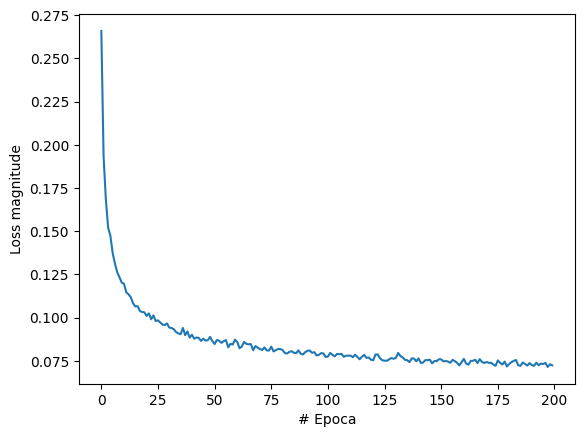

In [20]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(history.history["loss"])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embeddings_input    │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │     40,200 │ embeddings_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200)       │        800 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     12,864 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ km_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         64 │ km_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,552 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 166,333 (649.74 KB)

 Trainable params: 55,257 (215.85 KB)

 Non-trainable params: 560 (2.19 KB)

 Optimizer params: 110,516 (431.71 KB)

In [22]:
# Escalar los nuevos embeddings
new_embeddings_scaled = scaler_embeddings.transform(np.stack(test_df["embedding"].values))

# Escalar los nuevos 'km'
new_km_scaled = scaler_km.transform(test_df['km'].to_numpy().reshape(-1, 1))

print('Forma de new_embeddings_scaled:', new_embeddings_scaled.shape)
print('Forma de new_km_scaled:', new_km_scaled.shape)

Forma de new_embeddings_scaled: (33028, 200)
Forma de new_km_scaled: (33028, 1)


In [23]:
prediction = model.predict( 
            [
                new_embeddings_scaled, 
                new_km_scaled
            ] 
        ).flatten()

prediction = scaler_y.inverse_transform(prediction.reshape(-1, 1)).flatten()
realPrice = test_df['price'].to_numpy()

print('Forma de prediction:', prediction.shape)

print('Forma de price:', realPrice.shape)

  87/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step  

/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['embeddings_input', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step
Forma de prediction: (33028,)
Forma de price: (33028,)


In [25]:
result = pd.DataFrame({'Prediction': prediction, 'Real price': realPrice})

Evaluator.eval_regression(y_pred=result["Prediction"], y_true=result["Real price"], plot=False, n_features=2, regressor_name = "Fully_Connected")
Evaluator.save("Fully_Connected")

MAE: 2627.5069805508856 
 MSE: 87585018.49023251 
 RMSE: 9358.686793040599 
 R2: 0.8125608563423157 
 MAPE: 13.689706973551258
Mean: 2627.5069805508856
Variance: 80681225.55738889
Standard Deviation: 8982.272850308484
r2_adjusted: 0.8125495049937217
Regression results saved to: evaluation/Fully_Connected_regression.tex
Classification results saved to: evaluation/Fully_Connected_classification.tex


In [ ]:
model.save('models/model_2_text_km_to_price.keras')